In [2]:
"""
Classification of the Planet SuperDove imagery from the XGBoost model
Author: maxwell.cook@colorado.edu
"""

import os, time, sys
import xgboost as xgb

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [3]:
# results_dir = os.path.join(maindir, 'results/xgboost-cv/classification/')
results_dir = os.path.join(homedir, 'OPP/results/xgboost-cv/classification/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/


In [ ]:
# Load the reference footprint data

In [4]:
# ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
ref_fp = os.path.join(homedir,'OPP/training/denver/denver_data_reference_footprints.gpkg')
ref = gpd.read_file(ref_fp)
n_classes = len(ref['class_code'].unique())
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((501990.912 4396754.280, 502007..."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [5]:
# Create a dictionary mapping class_code to numeric code
ref['code'], _ = pd.factorize(ref['class_code'])
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'TL': 0, 'WS': 1, 'CN': 2, 'AP': 3, 'SL': 4, 'TG': 5, 'CS': 6}
Description map: 
{'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [ ]:
# Load the best XGBoost model from cross-validation based on holdout accuracy

In [6]:
best_fold = 1
best_params = {
    'learning_rate': 0.0017472223984262216,
    'max_depth': 6,
    'n_estimators': 982,
    'min_child_weight': 3,
    'subsample': 0.5002215027207308,
    'colsample_bytree': 0.5767395115585954,
    'gamma': 8.601053095855774e-05
}
print(best_params)

{'learning_rate': 0.0017472223984262216, 'max_depth': 6, 'n_estimators': 982, 'min_child_weight': 3, 'subsample': 0.5002215027207308, 'colsample_bytree': 0.5767395115585954, 'gamma': 8.601053095855774e-05}


In [7]:
# Load the trained model for best fold
# model_fp = os.path.join(maindir, f'results/xgboost-cv/denver-xgb_fold{best_fold}.model')
model_fp = os.path.join(homedir, f'OPP/results/xgboost-cv/dc-xgb_fold{best_fold}.model')
print(f"Loading model from path: {model_fp}")

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
    early_stopping_rounds=100, # stop if no improvement
    random_state=44
)

xgb_model.load_model(model_fp)
print("Model loaded !")

Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold1.model
Model loaded !


In [ ]:
# Load the Planet imagery

In [8]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/denver/denver_0815_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")

shape: (14939, 6330)
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [9]:
# Flatten the image for classification
stack_da_flat = flatten_array(stack_da)
stack_da_flat.shape

(94563870, 6)

In [ ]:
# Make predictions on the Planet imagery

In [14]:
t0 = time.time()

# Make predictions on the planet array
preds_ = xgb_model.predict(stack_da_flat)
# Get the height/width of the original image data
_, height, width = stack_da.shape
# Reshape the predictions
preds_r = preds_.reshape(height, width)

# Create a new datarray from the predictions, matching to the original Planet imagery
# Export to a GeoTIFF
out_fp = os.path.join(results_dir, 'denver-xgboost-best_roof_materials_pred.tif')
preds_da = array_to_xrda(preds_r, stack_da, dtype="uint8", clip=None, export=True, out_fp=out_fp)

print("\n~~~~~~~~~~~~~~~~~~~\n")
t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")

	Array of shape: (14939, 6330)
Successfully exported array to '/home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/denver-xgboost-best_roof_materials_pred.tif'

~~~~~~~~~~~~~~~~~~~

Total elapsed time: 22.64 minutes.


In [15]:
preds_da.shape

(14939, 6330)

In [16]:
print_raster(preds_da, open_file=False)

shape: (14939, 6330)
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 133625925
CRS: EPSG:32613
NoData: None


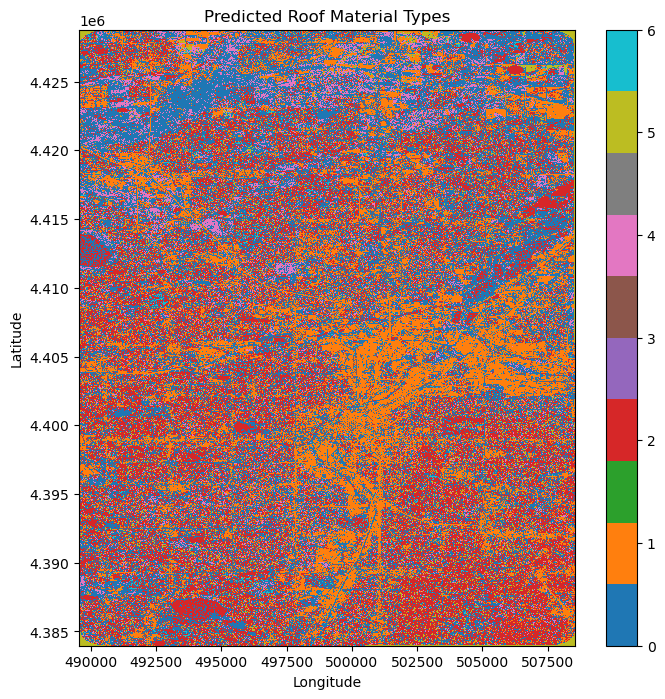

In [17]:
# Plotting the subset
plt.figure(figsize=(8, 8))
preds_da.plot(cmap="tab10", add_colorbar=True, vmin=0, vmax=6)
plt.title("Predicted Roof Material Types")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [20]:
# Mask by building footprints

from rasterio.features import geometry_mask

# Load all MS building footprints (raw)
fp = os.path.join(homedir, 'OPP/training/denver/denver-ms_footprints.gpkg')
footprints = gpd.read_file(fp)
footprints = footprints.to_crs(stack_da.rio.crs) # ensure projection matches

# Create a mask
mask = geometry_mask(
    [geom for geom in footprints.geometry],
    transform=preds_da.rio.transform(),
    invert=True,  # Invert to make buildings True
    out_shape=(preds_da.rio.height, preds_da.rio.width))

# Apply the mask
preds_masked = preds_da.where(mask)

# Export the raster
out_fp = os.path.join(results_dir, 'denver-xgboost-best_roof_materials_pred_mask.tif')
preds_da.rio.to_raster(
    out_fp, compress='zstd', zstd_level=9,
    dtype='uint8', driver='GTiff')

print(f"Successfully exported to {out_fp}!")

Successfully exported to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/denver-xgboost-best_roof_materials_pred_mask.tif!


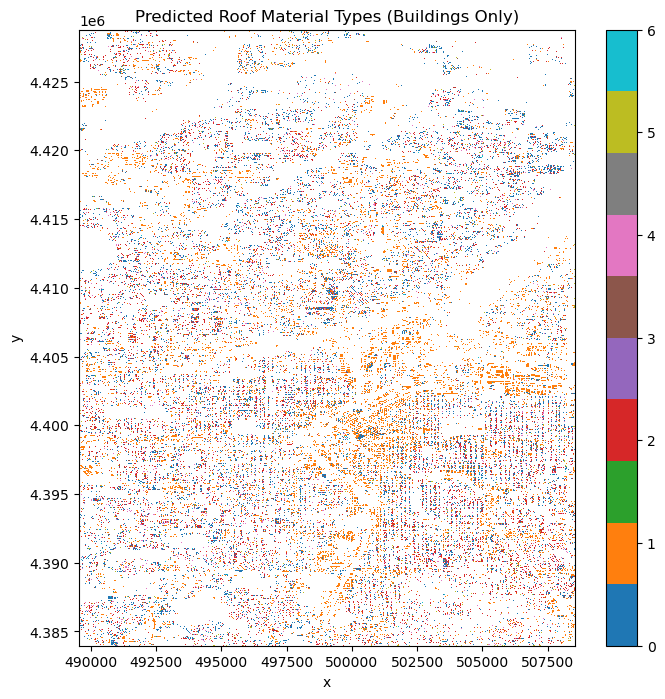

In [21]:
plt.figure(figsize=(8, 8))
preds_masked.plot(cmap="tab10", add_colorbar=True)
plt.title("Predicted Roof Material Types (Buildings Only)")
plt.show()